In [1]:
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, Dropout, MaxPool2D
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mnist = tf.keras.datasets.mnist

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
type(x_train)

numpy.ndarray

In [5]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

6


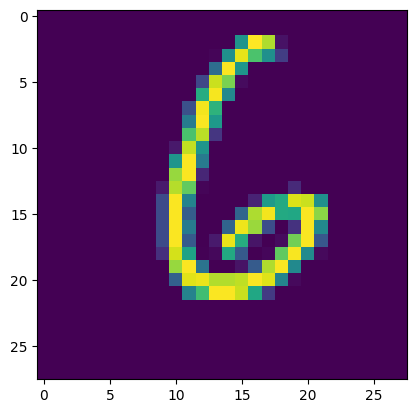

In [6]:
plt.imshow(x_train[32])
print(y_train[32])

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 64
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).cache().shuffle(len(x_train)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).cache().shuffle(len(x_test)).batch(batch_size)

train_ds = train_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

In [8]:
len(train_ds), len(test_ds)

(938, 157)

In [10]:

history = model.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5
938/938 [==============================] - 211s 219ms/step - loss: 0.2086 - accuracy: 0.9363 - val_loss: 0.0459 - val_accuracy: 0.9845
Epoch 2/5
938/938 [==============================] - 3318s 4s/step - loss: 0.0816 - accuracy: 0.9761 - val_loss: 0.0411 - val_accuracy: 0.9869
Epoch 3/5
938/938 [==============================] - 321s 333ms/step - loss: 0.0624 - accuracy: 0.9814 - val_loss: 0.0367 - val_accuracy: 0.9880
Epoch 4/5
938/938 [==============================] - 331s 353ms/step - loss: 0.0523 - accuracy: 0.9834 - val_loss: 0.0354 - val_accuracy: 0.9883
Epoch 5/5
938/938 [==============================] - 276s 294ms/step - loss: 0.0432 - accuracy: 0.9866 - val_loss: 0.0302 - val_accuracy: 0.9911


In [11]:
model.evaluate(test_ds)

157/157 [==============================] - 8s 50ms/step - loss: 0.0302 - accuracy: 0.9911


[0.03016294166445732, 0.991100013256073]

In [12]:
model.save('mnist.h5')

Prediction: 1
Actually: 1


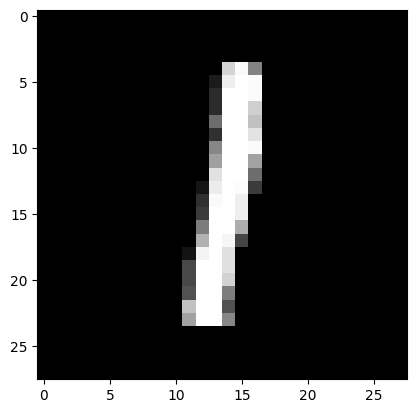

In [21]:
idx = 276

plt.imshow(x_test[idx], 'gray')

y_pred = model(np.expand_dims(x_test[idx], 0))
y_pred = np.argmax(y_pred)

print(f'Prediction: {y_pred}')

print(f'Actually: {y_test[idx]}')